### 에어비스의 플레이리스트 확인

In [33]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.tools import argparser
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
# pip install oauth2client

In [3]:
api_key = '-'
youtube_api_service_name = 'youtube'
youtube_api_version = 'v3'

youtube = build(youtube_api_service_name, youtube_api_version, developerKey = api_key)

In [4]:
search_response = youtube.search().list(q = '에어비스',
                                       order = 'relevance',
                                       part = 'snippet',
                                       maxResults = 50).execute()

In [5]:
channel_id = search_response['items'][0]['snippet']['channelId']

In [6]:
playlists = youtube.playlists().list(channelId = channel_id,
                                    part = 'snippet',
                                    maxResults = 20).execute()

In [7]:
ids = []
titles = []
for i in playlists['items']:
    ids.append(i['id'])
    titles.append(i['snippet']['title'])
    
df = pd.DataFrame([ids, titles])

In [8]:
df = df.T

In [9]:
df.columns = ['PlayLists', 'Titles']

In [10]:
df

,PlayLists,Titles
0,PLZvTAJaFMN4EWkPdrBqvUBMgh8CIYdxhT,【던파M】 클래식 던파의 완벽 구현 (DNF Mobile)
1,PLZvTAJaFMN4HGdNWBzpvlqxJ3_WL08FgD,에어비스의 일상(+육아Vlog)
2,PLZvTAJaFMN4Fi8d213AtVHdLogaWhKIt4,【던파】 PC던파의 모든 것


In [11]:
# pip install resource

# 특정 플레이리스트의 영상목록 가져오기

## 던파 M
#### 먼저 영상 타이틀과 각 영상의 id를 가져오기
- '【던파M】 클래식 던파의 완벽 구현 (DNF Mobile)' 목록의 영상들 불러오기.

In [12]:
# '던파M 클래식 던파의 완벽 구현'의 영상들

update_videos = df['PlayLists'][0]

playlist_videos = youtube.playlistItems().list(playlistId = update_videos,
                                              part = 'snippet',
                                              maxResults = 50) # 50개 동영상 뽑아보기
playlistitems_list_response = playlist_videos.execute()

video_names = []
video_ids = []
date = []

for v in playlistitems_list_response['items']:
    video_names.append(v['snippet']['title'])
    video_ids.append(v['snippet']['resourceId']['videoId'])
    date.append(v['snippet']['publishedAt'])


# 최대 50개 만 뽑을 수 있는 옵션 nextPageToken 사용해서 더 뽑기. (150개 추출).    
npt = playlistitems_list_response['nextPageToken']

for i in range(2):
    
    playlistitems_list_response = youtube.playlistItems().list(playlistId = update_videos,
                                                              part = 'snippet',
                                                              maxResults = 50,
                                                              pageToken = npt
                                                              ).execute()
    for v in playlistitems_list_response['items']:
        video_names.append(v['snippet']['title'])
        video_ids.append(v['snippet']['resourceId']['videoId'])
        date.append(v['snippet']['publishedAt'])
    
    if 'nextPageToken' in playlistitems_list_response.keys():
        npy = playlistitems_list_response['nextPageToken']
    else:
        break


video_df = pd.DataFrame([date, video_names, video_ids]).T
video_df.columns = ['Date', 'Title', 'IDS']

In [13]:
video_df

,Date,Title,IDS
0,2022-04-29T16:26:11Z,【던파M】 매주 개발자 노트를 쓰는 갓겜이 있다? 던파 모바일 항상 완벽했던 그 패...,a-2_77d77-E
1,2022-04-29T14:34:59Z,【던파M】 만렙 확장 어디까지 준비해 놓은 것입니까.. 던파 모바일 레인저 런처 6...,Ke-QZ29abZk
2,2022-04-29T10:07:04Z,"【던파M】 총 1,700만 원 진심이 통했습니다!!! 던파 모바일 에어비스 본캐 레...",2Ioq1Ph-ipw
3,2022-04-28T12:39:55Z,"【던파M】 드디어 등장한 근본 신캐! 던파 모바일 메카닉 스핏파이어 분석 및 추천,...",_cDiavweHS0
4,2022-04-28T06:28:07Z,【던파M】 최초의 레이드 던파 모바일 로터스 3페이즈 클리어 완료 및 난이도 패턴 ...,cmq8waU5VVo
...,...,...,...
145,2021-12-20T16:20:01Z,【던파M】 클래식 근본 그 자체! 던파 모바일 (DNF Mobile) 플레이,1sQgk51Lmvw
146,2021-11-25T04:43:11Z,【던파M】 상상 그 이상! 완벽 업그레이드 클래식 던파 등장 (던전앤파이터 모바일),ROLNtyARzOI
147,2021-11-01T14:36:00Z,【던파M】 업그레이드된 클래식 던파의 부활! 던파 모바일 국내 출시 확정,qYgn6eHmOEI
148,2020-11-24T02:27:57Z,【던파】 도대체 왜 이러는 걸까?,gopq16LEQ68


#### 조회수, 좋아요, 영상길이, 제목

In [14]:
# 해당 각 영상들의 정보 수집

import re

ids = []
dates = []
category_id = []
views = []
likes = []
dislikes = []
comments = []
title = []
mins = [] # 분
secs = [] # 초

for i in range(len(video_df)):
    request = youtube.videos().list(part = 'snippet, contentDetails, statistics',
                                   id = video_df['IDS'][i])
    response = request.execute()
    
    if response['items'] == []:
        ids.append('-')
        dates.append('-')
        category_id.append('-')
        views.append('-')
        likes.append('-')
        dislikes.append('-')
        comments.append('-')
        mins.append('-')
        secs.append('-')
    else:
        title.append(response['items'][0]['snippet']['title'])
        ids.append(video_df['IDS'][i])
        dates.append(response['items'][0]['snippet']['publishedAt'].split('T')[0])
        category_id.append(response['items'][0]['snippet']['categoryId'])
        views.append(response['items'][0]['statistics']['viewCount'])
        likes.append(response['items'][0]['statistics']['likeCount'])
        comments.append(response['items'][0]['statistics']['commentCount'])
        
update_videos_df = pd.DataFrame([title, ids, dates, category_id, views, likes, comments]).T
update_videos_df.columns = ['title', 'video_id', 'date', 'category_id', 'views', 'likes', 'comments']

In [15]:
update_videos_df

,title,video_id,date,category_id,views,likes,comments
0,【던파M】 매주 개발자 노트를 쓰는 갓겜이 있다? 던파 모바일 항상 완벽했던 그 패...,a-2_77d77-E,2022-04-29,20,12445,99,28
1,【던파M】 만렙 확장 어디까지 준비해 놓은 것입니까.. 던파 모바일 레인저 런처 6...,Ke-QZ29abZk,2022-04-29,20,47940,174,74
2,"【던파M】 총 1,700만 원 진심이 통했습니다!!! 던파 모바일 에어비스 본캐 레...",2Ioq1Ph-ipw,2022-04-29,20,50528,349,46
3,"【던파M】 드디어 등장한 근본 신캐! 던파 모바일 메카닉 스핏파이어 분석 및 추천,...",_cDiavweHS0,2022-04-28,20,56184,197,65
4,【던파M】 최초의 레이드 던파 모바일 로터스 3페이즈 클리어 완료 및 난이도 패턴 ...,cmq8waU5VVo,2022-04-28,20,74309,268,136
...,...,...,...,...,...,...,...
145,None,1sQgk51Lmvw,2021-12-20,20,216914,661,199
146,None,ROLNtyARzOI,2021-11-25,20,70744,258,148
147,None,qYgn6eHmOEI,2021-11-01,20,45277,221,138
148,None,gopq16LEQ68,2020-11-24,20,33096,162,66


In [17]:
update_videos_df.to_csv('C:/Users/dhckd/Study/CodingWorld/기술과제들/네오플/에어비스_M.csv')

## 던파 PC 목록가져오기

In [18]:
# '던파PC'의 영상들

update_videos = df['PlayLists'][2]

playlist_videos = youtube.playlistItems().list(playlistId = update_videos,
                                              part = 'snippet',
                                              maxResults = 50) # 50개 동영상 뽑아보기
playlistitems_list_response = playlist_videos.execute()

video_names = []
video_ids = []
date = []

for v in playlistitems_list_response['items']:
    video_names.append(v['snippet']['title'])
    video_ids.append(v['snippet']['resourceId']['videoId'])
    date.append(v['snippet']['publishedAt'])


# 최대 50개 만 뽑을 수 있는 옵션 nextPageToken 사용해서 더 뽑기. (150개 추출).    
npt = playlistitems_list_response['nextPageToken']

for i in range(2):
    
    playlistitems_list_response = youtube.playlistItems().list(playlistId = update_videos,
                                                              part = 'snippet',
                                                              maxResults = 50,
                                                              pageToken = npt
                                                              ).execute()
    for v in playlistitems_list_response['items']:
        video_names.append(v['snippet']['title'])
        video_ids.append(v['snippet']['resourceId']['videoId'])
        date.append(v['snippet']['publishedAt'])
    
    if 'nextPageToken' in playlistitems_list_response.keys():
        npy = playlistitems_list_response['nextPageToken']
    else:
        break


video_df = pd.DataFrame([date, video_names, video_ids]).T
video_df.columns = ['Date', 'Title', 'IDS']

In [19]:
video_df

,Date,Title,IDS
0,2022-04-27T19:54:20Z,【던파】 점유율 3프로 갓겜을 위한 윤명진 디렉터의 골든 베릴 퍼주는 이벤트 설계 ...,v55ANXwKItE
1,2022-04-27T14:16:25Z,"【던파】 무자본, 뉴비, 복귀, 서민 여러분들 명성 3.3 할 수 있습니다",H08yCpsZPQs
2,2022-04-25T11:37:01Z,【던파】 진짜 처음 봤습니다 초특급 희귀 영상! 모든 히든압 풀셋 완성 ㅁㅊ,Mn3utrrhAeo
3,2022-04-24T13:42:54Z,【던파】 레전드 에픽 세팅ㅋㅋ 아무도 안 쓰는 이유가 있었다,Q9B801M1oUo
4,2022-04-23T06:20:36Z,【던파】 힘숨찐 에어비스 본캐 데페 근황,H8lvA6ojczU
...,...,...,...
145,2022-01-27T08:32:07Z,【던파】 그냥 따라하세요 시공간 여행자 오라 획득 무지성 루트,FMpJX4Nr2e0
146,2022-01-27T03:30:47Z,【던파】 종결 히든 차원 여행 패키지 제발 이대로만 하세요!! (+설날 이벤트 총정리),1admIM2RGpU
147,2022-01-26T18:22:17Z,【던파】 띵진이의 약속! 설날 이벤트 종결 패키지 미리보기,zDwPIXqe6Tw
148,2022-01-26T14:23:03Z,【던파】 그 때 그 시절의 추억 부활! 2월 업데이트 진 : 이계 던전 선공개 플레...,jH4urcJs0H0


In [21]:
# 해당 각 영상들의 정보 수집

import re

ids = []
dates = []
category_id = []
views = []
likes = []
dislikes = []
comments = []
title = []
mins = [] # 분
secs = [] # 초

for i in range(len(video_df)):
    request = youtube.videos().list(part = 'snippet, contentDetails, statistics',
                                   id = video_df['IDS'][i])
    response = request.execute()
    
    if response['items'] == []:
        ids.append('-')
        dates.append('-')
        category_id.append('-')
        views.append('-')
        likes.append('-')
        dislikes.append('-')
        comments.append('-')
        mins.append('-')
        secs.append('-')
    else:
        title.append(response['items'][0]['snippet']['title'])
        ids.append(video_df['IDS'][i])
        dates.append(response['items'][0]['snippet']['publishedAt'].split('T')[0])
        category_id.append(response['items'][0]['snippet']['categoryId'])
        views.append(response['items'][0]['statistics']['viewCount'])
        likes.append(response['items'][0]['statistics']['likeCount'])
        comments.append(response['items'][0]['statistics']['commentCount'])
        
update_videos_df = pd.DataFrame([title, ids, dates, category_id, views, likes, comments]).T
update_videos_df.columns = ['title', 'video_id', 'date', 'category_id', 'views', 'likes', 'comments']

In [22]:
update_videos_df

,title,video_id,date,category_id,views,likes,comments
0,【던파】 점유율 3프로 갓겜을 위한 윤명진 디렉터의 골든 베릴 퍼주는 이벤트 설계 ...,v55ANXwKItE,2022-04-27,20,10117,46,12
1,"【던파】 무자본, 뉴비, 복귀, 서민 여러분들 명성 3.3 할 수 있습니다",H08yCpsZPQs,2022-04-27,20,21164,88,51
2,【던파】 진짜 처음 봤습니다 초특급 희귀 영상! 모든 히든압 풀셋 완성 ㅁㅊ,Mn3utrrhAeo,2022-04-25,20,30860,92,18
3,【던파】 레전드 에픽 세팅ㅋㅋ 아무도 안 쓰는 이유가 있었다,Q9B801M1oUo,2022-04-24,20,32515,144,60
4,【던파】 힘숨찐 에어비스 본캐 데페 근황,H8lvA6ojczU,2022-04-23,20,46091,138,41
...,...,...,...,...,...,...,...
145,【던파】 그냥 따라하세요 시공간 여행자 오라 획득 무지성 루트,FMpJX4Nr2e0,2022-01-27,20,31631,234,13
146,【던파】 종결 히든 차원 여행 패키지 제발 이대로만 하세요!! (+설날 이벤트 총정리),1admIM2RGpU,2022-01-27,20,54080,257,61
147,【던파】 띵진이의 약속! 설날 이벤트 종결 패키지 미리보기,zDwPIXqe6Tw,2022-01-26,20,23912,164,41
148,【던파】 그 때 그 시절의 추억 부활! 2월 업데이트 진 : 이계 던전 선공개 플레...,jH4urcJs0H0,2022-01-26,20,50623,186,70


In [23]:
update_videos_df.to_csv('C:/Users/dhckd/Study/CodingWorld/기술과제들/네오플/에어비스_PC.csv')

In [28]:
df_M = pd.read_csv('C:/Users/dhckd/Study/CodingWorld/기술과제들/네오플/에어비스_M.csv', index_col = 0)

In [29]:
df_PC = pd.read_csv('C:/Users/dhckd/Study/CodingWorld/기술과제들/네오플/에어비스_PC.csv', index_col = 0)

In [35]:
df_M = df_M.sort_values(by = 'date', ascending = True)

In [36]:
df_PC = df_PC.sort_values(by = 'date', ascending = True)

### 던파 PC 그래프

In [70]:
# 데이터 필터링. 
# - 값 가진 데이터 제거
condition = df_PC.video_id != '-'
df_PC_new = df_PC.loc[condition, :]
# 2월 24일 이후 데이터 확인. 던파 PC가 던파 M이 출시됨에 따라 조회수가 변동하였는지 보기위해
condition2 = df_PC_new.date >= '2022-02-24'
df_PC_new = df_PC_new.loc[condition2, :]
# 결측값 제거
df_PC_new = df_PC_new.dropna()

# views 데이터 타입 str에서 int로 변경
df_PC_new = df_PC_new.astype({'views':'int'})

In [83]:
# 한 날짜에 여러 동영상을 올리는 경우가 있다. 이 경우엔 영상들의 조회수 합을 구해야하기 때문에 groupby 사용
df_PC_new_views = df_PC_new.groupby('date').sum()

<BarContainer object of 41 artists>

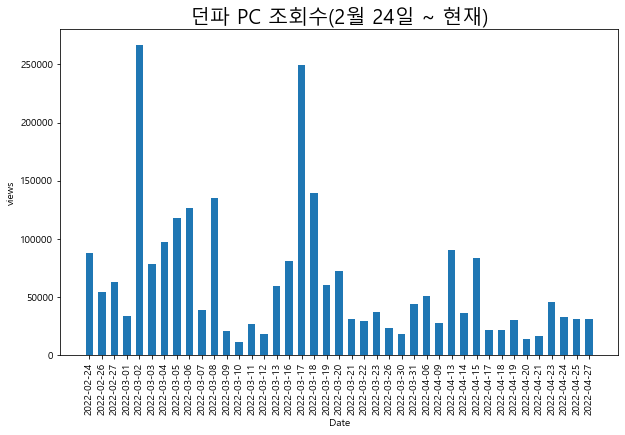

In [84]:
xs = df_PC_new_views.index
ys = df_PC_new_views['views']
plt.figure(figsize=(10, 6)) #그래프 크기 지정
plt.xlabel('Date') #그래프 x축 이름(label) 지정
plt.ylabel('views') #그래프 y축 이름(label) 지정
plt.xticks(rotation = 90)
plt.title('던파 PC 조회수(2월 24일 ~ 현재)',fontsize=20) ## 타이틀 설정
plt.bar(xs, ys, width=0.6) #리스트로 저장한 xs와 ys로 막대(bar) 그래프 플롯

### 던파 M 그래프

In [68]:
# 데이터 필터링. 
# - 값 가진 데이터 제거
condition = df_M.video_id != '-'
df_M_new = df_M.loc[condition, :]
# 3월 24일 이전 데이터 제거. 던파 M이니까
condition2 = df_M_new.date >= '2022-03-24'
df_M_new = df_M_new.loc[condition2, :]
# 결측값 제거
df_M_new = df_M_new.dropna()

# views 데이터 타입 str에서 int로 변경
df_M_new = df_M_new.astype({'views':'int'})

In [85]:
# 한 날짜에 여러 동영상을 올리는 경우가 있다. 이 경우엔 영상들의 조회수 합을 구해야하기 때문에 groupby 사용
df_M_new_views = df_M_new.groupby('date').sum()

<BarContainer object of 37 artists>

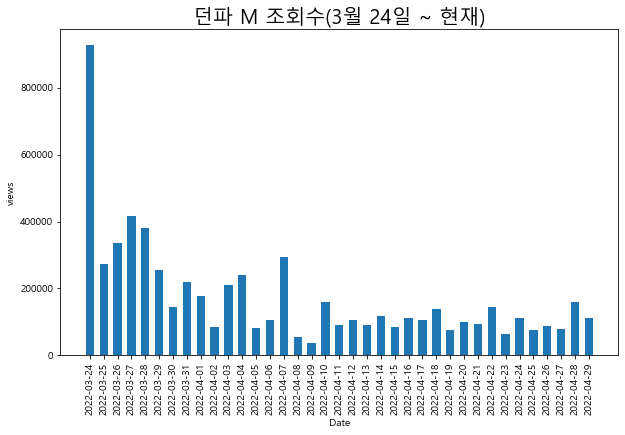

In [86]:
xs = df_M_new_views.index
ys = df_M_new_views['views']
plt.figure(figsize=(10, 6)) #그래프 크기 지정
plt.xlabel('Date') #그래프 x축 이름(label) 지정
plt.ylabel('views') #그래프 y축 이름(label) 지정
plt.xticks(rotation = 90)
plt.title('던파 M 조회수(3월 24일 ~ 현재)',fontsize=20) ## 타이틀 설정
plt.bar(xs, ys, width=0.6) #리스트로 저장한 xs와 ys로 막대(bar) 그래프 플롯